# Multicompartment Modeling of Influenza A Replication Along the Murine Respiratory Tract

*Authors: Rodolfo Blanco-Rodriguez, L. America Chi, Esteban Hernandez-Vargas*

## 0. Importing Essential Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
# from scipy.interpolate import interp1d
# from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
import seaborn as sns

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

viridis_pal = sns.color_palette('viridis', n_colors=8)
rocket_pal = sns.color_palette('rocket', n_colors=3)

## 1. Models

The system is divided into three compartments representing different anatomical regions of the mouse respiratory system: the nose ($i=1$), trachea ($i=2$), and lungs ($i=3$).

\begin{align}
\dot{U}_i &= -\beta_i U_i V_i - \xi_i U_i F_i, \\
\dot{I}_i &= \beta_i U_i V_i - \delta_i I_i - k_i T I_i, \\
\dot{F}_i &= \alpha_i I_i - \phi_i F_i, \\
\dot{V}_i &= p_i I_i - c_i V_i + \sum_{j=1}^3 \Gamma_{ij} V_j \\
\dot{T}   &= s_T + r T\sum_{i=1}^{3} I_i - \mu T
\end{align}

where:
$$ \Gamma = \begin{pmatrix}
    -\gamma_{12} & \gamma_{21} & 0 \\
    \gamma_{12} & -\gamma_{21} - \gamma_{23} & \gamma_{32} \\
    0 & \gamma_{23} & -\gamma_{32}
    \end{pmatrix} $$

In [2]:
def safeLog10(x, eps=1e-8):
    return np.log10(x + eps)

In [3]:
def fullModel(y, t, params, M):
    # Unpack state variables
    U1, U2, U3, I1, I2, I3, F1, F2, F3, V1, V2, V3, T = y

    # arrays of shape (3,)
    beta = 10**params['beta']
    delta = np.array([1.8, 1.8, 1.8])
    p = np.array([1.0, 1.0, 1.0])
    c = np.array([4.2, 4.2, 4.2])

    xi = 10**params['xi'] # or rho for M2
    k = 10**params['k']
    alpha = 10**params['alpha']
    phi = np.array([2.0, 2.0, 2.0])

    # For the Gamma matrix:
    gamma12 = 10**params['gamma12']
    gamma21 = 10**params['gamma21']
    gamma23 = 10**params['gamma23']
    gamma32 = 10**params['gamma32']

    # Immune parameters
    r = 10**params['r']
    mu = 0.011
    s_T = mu*params['T_0']
    
    # Construct Gamma matrix
    Gamma = np.array([
        [-gamma12,  gamma21,       0],
        [ gamma12, -gamma21-gamma23, gamma32],
        [      0,  gamma23,     -gamma32]
    ])
    
    U = np.array([U1, U2, U3])
    I = np.array([I1, I2, I3])
    F = np.array([F1, F2, F3])
    V = np.array([V1, V2, V3])
    
    # Compute derivatives
    if M == 1:
        dU_dt = -beta * U * V
        dI_dt = beta * U * V - delta * I
        dF_dt = np.array([0.0, 0.0, 0.0])
        dV_dt = p * I - c * V + Gamma.dot(V)
        dT_dt = 0.0

    if M == 2:
        dU_dt = -beta * U * V - xi * U * I
        dI_dt = beta * U * V - delta * I
        dF_dt = np.array([0.0, 0.0, 0.0])
        dV_dt = p * I - c * V + Gamma.dot(V)
        dT_dt = 0.0

    if M == 3:
        dU_dt = -beta * U * V - xi * U * F
        dI_dt = beta * U * V - delta * I - k * T * I
        dF_dt = alpha * I - phi * F
        dV_dt = p * I - c * V + Gamma.dot(V)
        dT_dt = 0.0

    if M == 4:
        dU_dt = -beta * U * V
        dI_dt = beta * U * V - delta * I - k * T * I
        dF_dt = np.array([0.0, 0.0, 0.0])
        dV_dt = p * I - c * V + Gamma.dot(V)
        dT_dt = s_T + r * T * np.sum(I) - mu * T
        # dT_dt = s_T + r * T * np.sum(V) - mu * T
    
    # Concatenate derivatives into a single array
    dydt = np.concatenate([dU_dt, dI_dt, dF_dt, dV_dt, [dT_dt]])
    
    return dydt

The respiratory tract consist in nasal Cavity, trachea, and lungs. In a mouse the quantity of susceptble cells per compartament is estimated to:

| Compartment | Area | Cells |
|--- | ---| ---|
|Nose | $3 \times 10^8 \  \mu$m$^2$ (Asahi et al. 2002) | $3 \times 10^6$ |
|Trachea | $2 \times 10^5 \ \mu$m$^2$ (Kishimoto et al. 2021) | $2 \times 10^3$ |
|Lungs | $80 \times 10^8 \ \mu$m$^2$ (Knust et al. 2009) | $4 \times 10^6$ |

considering a surface area for one ciliated epithelial cell of 100 $\mu$m$^2$ for Nose and Trachea (Lawson et al. 2002), and a diameter of one alvealar type I cell of 50 $\mu$m, ~ 2000 $\mu$m$^2$ (Cheng et al. 2004) for Lungs.

### 1.1. Model 1 - Simulation

In [4]:
# Using a data file
paramsM1 = pd.read_csv('data/bestPars_M1.csv')

paramsM1

,V1_0,T_0,beta,xi,k,alpha,gamma12,gamma21,gamma23,gamma32,r,LRSS
0,115.87503,1.000000e-10,-4.814853,-10.0,-10.0,-10.0,-0.293141,-2.705313,-0.019907,-3.461329,-10.0,12.335501
1,115.87503,1.000000e-10,-4.007000,-10.0,-10.0,-10.0,-0.293141,-2.705313,-0.019907,-3.461329,-10.0,12.335501
2,115.87503,1.000000e-10,-6.742086,-10.0,-10.0,-10.0,-0.293141,-2.705313,-0.019907,-3.461329,-10.0,12.335501


In [5]:
params = paramsM1
pars = {
        'V1_0': params['V1_0'][0],
        'T_0': params['T_0'][0],
        'beta': np.array([params['beta'][0], params['beta'][1], params['beta'][2]]),
        'xi': np.array([params['xi'][0], params['xi'][1], params['xi'][2]]),
        'k': np.array([params['k'][0], params['k'][1], params['k'][2]]),
        'alpha': np.array([params['alpha'][0], params['alpha'][1], params['alpha'][2]]),
        'gamma12': params['gamma12'][0],
        'gamma21': params['gamma21'][0],
        'gamma23': params['gamma23'][0],
        'gamma32': params['gamma32'][0],
        'r': params['r'][0],
    }

# Initial conditions
M = 1
U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
y0 = [U1_0, U2_0, U3_0]+ 10*[0.0]
y0[9] = pars['V1_0']

t = np.linspace(0,10,1000)
    
# Run your ODE model
sol = odeint(fullModel, y0, t, args=(pars, M))

In [6]:
U_M1 = sol[:, 0:3]
I_M1 = sol[:, 3:6]
V_M1 = sol[:, 9:12]

LRSS_M1 = paramsM1['LRSS'][0]
print(f"LRSS_M1 = {LRSS_M1}")

LRSS_M1 = 12.33550135311165


### 1.2. Model 2 - Simulation

In [7]:
# Using a data file
paramsM2 = pd.read_csv('data/bestPars_M2.csv')

paramsM2

,V1_0,T_0,beta,xi,k,alpha,gamma12,gamma21,gamma23,gamma32,r,LRSS
0,120.098797,1.000000e-10,-4.828062,-6.903920,-10.0,-10.0,-0.308372,-2.063891,0.044498,-3.785575,-10.0,12.410939
1,120.098797,1.000000e-10,-5.462834,-5.492918,-10.0,-10.0,-0.308372,-2.063891,0.044498,-3.785575,-10.0,12.410939
2,120.098797,1.000000e-10,-6.845964,-4.576824,-10.0,-10.0,-0.308372,-2.063891,0.044498,-3.785575,-10.0,12.410939


In [8]:
params = paramsM2
pars = {
        'V1_0': params['V1_0'][0],
        'T_0': params['T_0'][0],
        'beta': np.array([params['beta'][0], params['beta'][1], params['beta'][2]]),
        'xi': np.array([params['xi'][0], params['xi'][1], params['xi'][2]]),
        'k': np.array([params['k'][0], params['k'][1], params['k'][2]]),
        'alpha': np.array([params['alpha'][0], params['alpha'][1], params['alpha'][2]]),
        'gamma12': params['gamma12'][0],
        'gamma21': params['gamma21'][0],
        'gamma23': params['gamma23'][0],
        'gamma32': params['gamma32'][0],
        'r': params['r'][0],
    }

# Initial conditions
M = 2
U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
y0 = [U1_0, U2_0, U3_0]+ 10*[0.0]
y0[9] = pars['V1_0']

t = np.linspace(0,10,1000)
    
# Run your ODE model
sol = odeint(fullModel, y0, t, args=(pars, M))

In [9]:
U_M2 = sol[:, 0:3]
I_M2 = sol[:, 3:6]
V_M2 = sol[:, 9:12]

LRSS_M2 = paramsM2['LRSS'][0]
print(f"LRSS_M2 = {LRSS_M2}")

LRSS_M2 = 12.41093881287028


### 1.3. Model 3 - Simulation

In [10]:
# Using a data file
paramsM3 = pd.read_csv('data/bestPars_M3.csv')

paramsM3

,V1_0,T_0,beta,xi,k,alpha,gamma12,gamma21,gamma23,gamma32,r,LRSS
0,117.182503,1.000000e-10,-4.819515,-2.083897,-10.0,-4.859972,-0.297054,-1.507258,-0.034495,-2.440967,-10.0,12.308027
1,117.182503,1.000000e-10,-5.338682,-4.167629,-10.0,-4.045883,-0.297054,-1.507258,-0.034495,-2.440967,-10.0,12.308027
2,117.182503,1.000000e-10,-6.634260,-1.492053,-10.0,-2.204080,-0.297054,-1.507258,-0.034495,-2.440967,-10.0,12.308027


In [11]:
params = paramsM3
pars = {
        'V1_0': params['V1_0'][0],
        'T_0': params['T_0'][0],
        'beta': np.array([params['beta'][0], params['beta'][1], params['beta'][2]]),
        'xi': np.array([params['xi'][0], params['xi'][1], params['xi'][2]]),
        'k': np.array([params['k'][0], params['k'][1], params['k'][2]]),
        'alpha': np.array([params['alpha'][0], params['alpha'][1], params['alpha'][2]]),
        'gamma12': params['gamma12'][0],
        'gamma21': params['gamma21'][0],
        'gamma23': params['gamma23'][0],
        'gamma32': params['gamma32'][0],
        'r': params['r'][0],
    }

# Initial conditions
M = 3
U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
y0 = [U1_0, U2_0, U3_0]+ 10*[0.0]
y0[9] = pars['V1_0']

t = np.linspace(0,10,1000)
    
# Run your ODE model
sol = odeint(fullModel, y0, t, args=(pars, M))

In [12]:
U_M3 = sol[:, 0:3]
I_M3 = sol[:, 3:6]
F_M3 = sol[:, 6:9]
V_M3 = sol[:, 9:12]

LRSS_M3 = paramsM3['LRSS'][0]
print(f"LRSS_M3 = {LRSS_M3}")

LRSS_M3 = 12.308027419543318


### 1.4. Model 4 - Simulation

In [13]:
# Using a data file
paramsM4 = pd.read_csv('data/bestPars_M4.csv')

paramsM4

,V1_0,T_0,beta,xi,k,alpha,gamma12,gamma21,gamma23,gamma32,r,LRSS
0,41.306291,500034.534977,-4.480279,-10.0,-5.725276,-10.0,-1.010344,0.87497,-0.225384,1.0,-6.004531,9.802614
1,41.306291,500034.534977,-6.122452,-10.0,-5.636423,-10.0,-1.010344,0.87497,-0.225384,1.0,-6.004531,9.802614
2,41.306291,500034.534977,-4.566418,-10.0,-5.717875,-10.0,-1.010344,0.87497,-0.225384,1.0,-6.004531,9.802614


In [14]:
params = paramsM4
pars = {
        'V1_0': params['V1_0'][0],
        'T_0': params['T_0'][0],
        'beta': np.array([params['beta'][0], params['beta'][1], params['beta'][2]]),
        'xi': np.array([params['xi'][0], params['xi'][1], params['xi'][2]]),
        'k': np.array([params['k'][0], params['k'][1], params['k'][2]]),
        'alpha': np.array([params['alpha'][0], params['alpha'][1], params['alpha'][2]]),
        'gamma12': params['gamma12'][0],
        'gamma21': params['gamma21'][0],
        'gamma23': params['gamma23'][0],
        'gamma32': params['gamma32'][0],
        'r': params['r'][0],
    }

# Initial conditions
M = 4
U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
y0 = [U1_0, U2_0, U3_0]+ 10*[0.0]
y0[9] = pars['V1_0']
y0[12] = pars['T_0']

t = np.linspace(0,10,1000)
    
# Run your ODE model
sol = odeint(fullModel, y0, t, args=(pars, M))

In [15]:
U_M4 = sol[:, 0:3]
I_M4 = sol[:, 3:6]
F_M4 = sol[:, 6:9]
V_M4 = sol[:, 9:12]
T_M4 = sol[:, 12]

LRSS_M4 = paramsM4['LRSS'][0]
print(f"LRSS_M4 = {LRSS_M4}")

LRSS_M4 = 9.80261382714368


### 1.5. Plot models

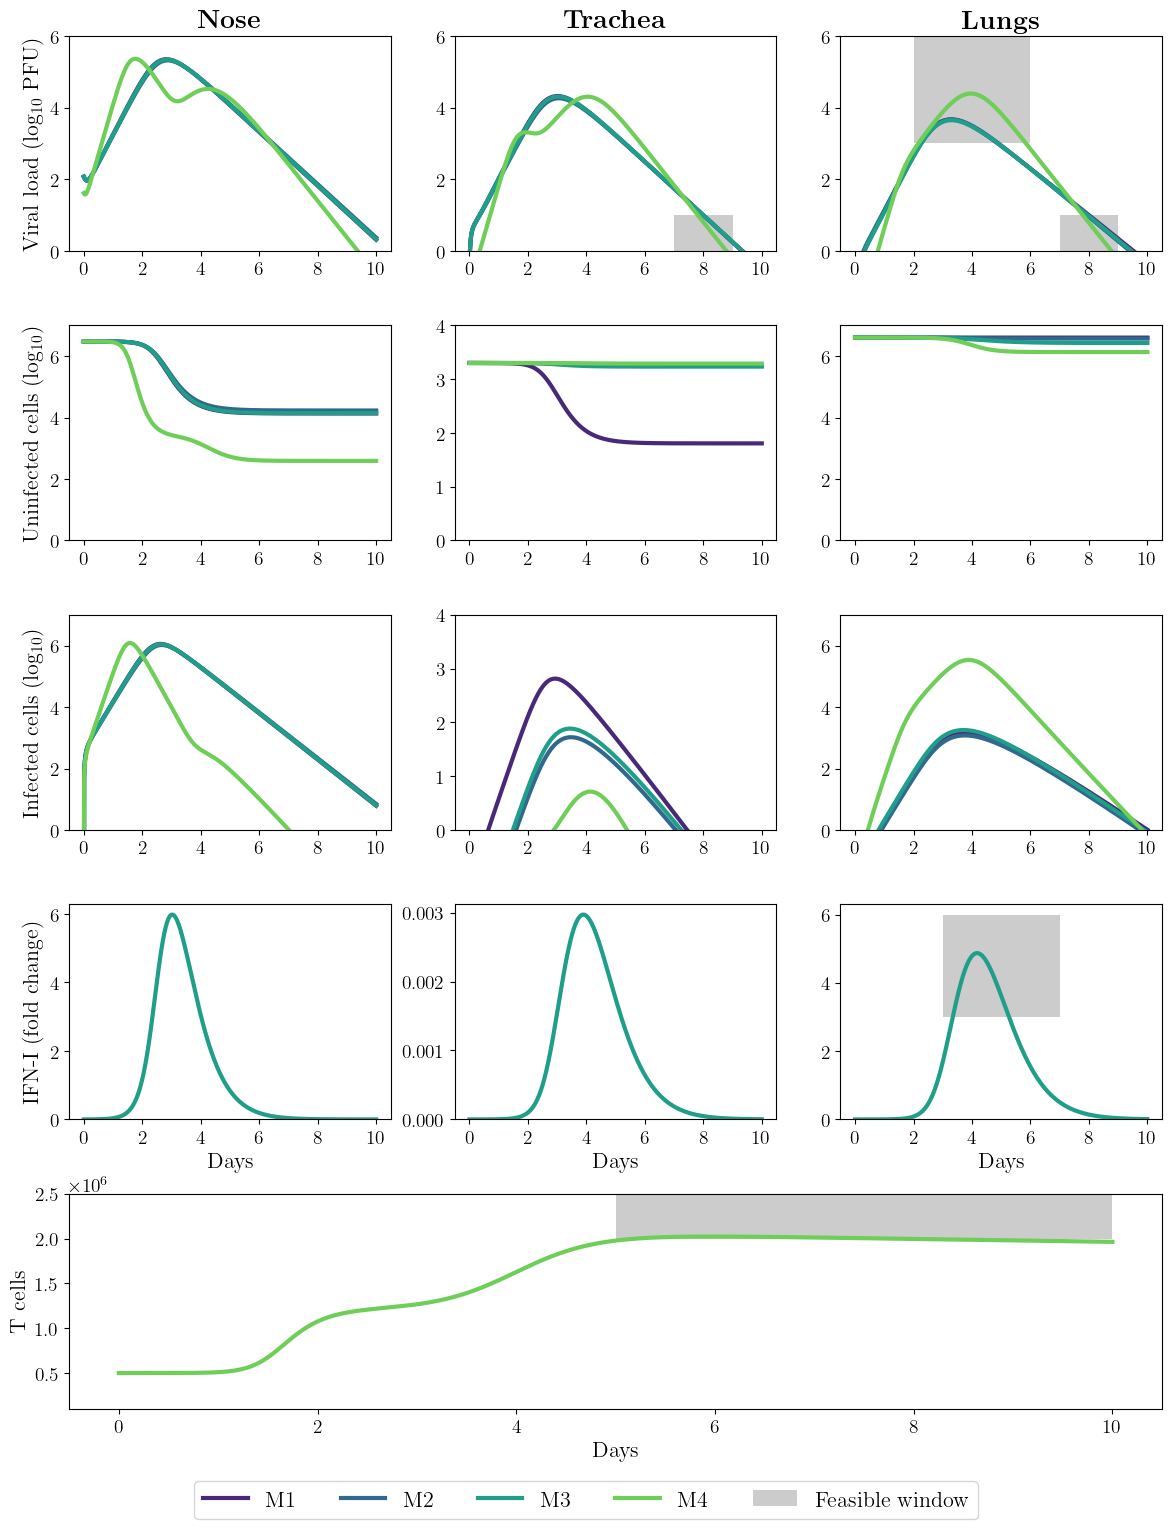

In [16]:
# Plots
fig = plt.figure(figsize=(12, 15))
gs = gridspec.GridSpec(5, 3, height_ratios=[1, 1, 1, 1, 1])

for idx in range(3):
    # Row 1: V kinetics (columns)
    ax = fig.add_subplot(gs[0, idx])
    ax.plot(t, safeLog10(V_M1[:, idx]), color=viridis_pal[0], lw=3, label="M1")
    ax.plot(t, safeLog10(V_M2[:, idx]), color=viridis_pal[2], lw=3, label="M2")
    ax.plot(t, safeLog10(V_M3[:, idx]), color=viridis_pal[4], lw=3, label="M3")
    ax.plot(t, safeLog10(V_M4[:, idx]), color=viridis_pal[6], lw=3, label="M4")
    if idx == 0:
        ax.set_ylabel("Viral load (log$_{10}$ PFU)")
        ax.set_title(r"\bf{Nose}")
    if idx == 1:
        ax.set_title(r"\bf{Trachea}")
        tmin, tmax = 7, 9
        vmin, vmax = 0, 1
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)
    if idx == 2:
        ax.set_title(r"\bf{Lungs}")
        tmin, tmax = 2, 6
        vmin, vmax = 3, 6
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1, label="Feasible window")
        ax.add_patch(rect)

        tmin, tmax = 7, 9
        vmin, vmax = 0, 1
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)

        handles, labels = ax.get_legend_handles_labels()
        
    ax.set_ylim((0, 6))

    # Row 2: U kinetics for i=1,2,3 (columns)
    ax = fig.add_subplot(gs[1, idx])
    ax.plot(t, safeLog10(U_M1[:, idx]), color=viridis_pal[0], lw=3, label="U")
    ax.plot(t, safeLog10(U_M2[:, idx]), color=viridis_pal[2], lw=3)
    ax.plot(t, safeLog10(U_M3[:, idx]), color=viridis_pal[4], lw=3)
    ax.plot(t, safeLog10(U_M4[:, idx]), color=viridis_pal[6], lw=3)
    
    if idx == 0:
        ax.set_ylabel("Uninfected cells (log$_{10}$)")
        ax.set_ylim((0,7))
    if idx == 1:
        ax.set_ylim((0,4))
    if idx == 2:
        ax.set_ylim((0,7))

    # Row 3: I kinetics for i=1,2,3 (columns)
    ax = fig.add_subplot(gs[2, idx])
    ax.plot(t, safeLog10(I_M1[:, idx]), color=viridis_pal[0], lw=3, label="I")
    ax.plot(t, safeLog10(I_M2[:, idx]), color=viridis_pal[2], lw=3)
    ax.plot(t, safeLog10(I_M3[:, idx]), color=viridis_pal[4], lw=3)
    ax.plot(t, safeLog10(I_M4[:, idx]), color=viridis_pal[6], lw=3)
    
    if idx == 0:
        ax.set_ylabel("Infected cells (log$_{10}$)")
        ax.set_ylim((0,7))
    if idx == 1:
        ax.set_ylim((0,4))
    if idx == 2:
        ax.set_ylim((0,7))
    
    # Row 3: F kinetics for i=1,2,3 (columns)
    ax = fig.add_subplot(gs[3, idx])
    ax.plot(t, F_M3[:, idx], color=viridis_pal[4], lw=3, label="IFN")
    if idx == 0:
        ax.set_ylabel("IFN-I (fold change)")
    if idx == 2:
        tmin, tmax = 3, 7
        fmin, fmax = 3, 6
        rect = plt.Rectangle((tmin, fmin), tmax-tmin, fmax-fmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)
    ax.set_ylim((0))
    ax.set_xlabel("Days")
    # ax.legend()

# Row 4: one plot spanning all three columns for T cell kinetics
ax = fig.add_subplot(gs[4, :])
ax.plot(t, T_M4, color=viridis_pal[6], lw=3, label="T cell")
tmin, tmax = 5, 10
Tmin, Tmax = 2e6, 5e6
rect = plt.Rectangle((tmin, Tmin), tmax-tmin, Tmax-Tmin, fc='gray', alpha = 0.4, zorder=-1)
ax.add_patch(rect)
ax.set_ylim((1e5, 2.5e6))

ax.set_ylabel("T cells")
ax.set_xlabel("Days")

fig.legend(handles, labels, loc="lower center", ncol=6, frameon=True, bbox_to_anchor=(0.5, -0.03))
# fig.legend(handles, labels, loc="lower center", ncol=6, frameon=True)

for ax in fig.axes:
    ax.xaxis.set_major_locator(MultipleLocator(2))

plt.tight_layout(h_pad=0.2, w_pad=0.5)

plt.show()

## 6. Bootstraping

In [17]:
def model_M1(y, t, params):
    # Unpack state variables
    U1, U2, U3, I1, I2, I3, V1, V2, V3 = y

    # arrays of shape (3,)
    beta = 10**params['beta']
    delta = np.array([1.8, 1.8, 1.8])
    p = np.array([1.0, 1.0, 1.0])
    c = np.array([4.2, 4.2, 4.2])

    # For the Gamma matrix:
    gamma12 = 10**params['gamma12']
    gamma21 = 10**params['gamma21']
    gamma23 = 10**params['gamma23']
    gamma32 = 10**params['gamma32']
    
    # Construct Gamma matrix
    Gamma = np.array([
        [-gamma12,  gamma21,       0],
        [ gamma12, -gamma21-gamma23, gamma32],
        [      0,  gamma23,     -gamma32]
    ])
    
    U = np.array([U1, U2, U3])
    I = np.array([I1, I2, I3])
    V = np.array([V1, V2, V3])
    
    # Compute derivatives
    dU_dt = -beta * U * V
    dI_dt = beta * U * V - delta * I
    dV_dt = p * I - c * V + Gamma.dot(V)
    
    dydt = np.concatenate([dU_dt, dI_dt, dV_dt])
    return dydt

In [18]:
def simulations(dfPars):
    # Initial conditions
    U1_0, U2_0, U3_0 = 3e6, 2e3, 4e6
    initialCond = [U1_0, U2_0, U3_0]+ 6*[0.0]

    U = []
    I = []
    V = []

    simNum = dfPars.shape[0]
    for i in range(simNum):
        pars = {
                'V1_0': 10**dfPars['V1_0'][i],
                'beta': np.array([dfPars['beta1'][i], dfPars['beta2'][i], dfPars['beta3'][i]]),
                'gamma12': dfPars['gamma12'][i],
                'gamma21': dfPars['gamma21'][i],
                'gamma23': dfPars['gamma23'][i],
                'gamma32': dfPars['gamma32'][i],
            }

        y0 = initialCond.copy()
        y0[6] = pars['V1_0']
        t = np.linspace(0, 10, 1000)

        sol = odeint(model_M1, y0, t, args=(pars,))

        U.append(sol[:, 0:3])
        I.append(sol[:, 3:6])
        V.append(sol[:, 6:9])

    return np.array([U, I, V])

In [19]:
def kinetics(X):
    t = np.linspace(0, 10, 1000)
    
    # statistics over simulations (axis=0)
    median = np.median(X, axis=0)           # shape (1000, 3)
    low = np.percentile(X, 2.5, axis=0)     # 2.5th percentile for 95% CI lower bound
    high = np.percentile(X, 97.5, axis=0)   # 97.5th percentile for 95% CI upper bound
    
    # build DataFrame
    df = pd.DataFrame(np.column_stack([
            t,
            median[:, 0], low[:, 0], high[:, 0],   # nose
            median[:, 1], low[:, 1], high[:, 1],   # trachea
            median[:, 2], low[:, 2], high[:, 2],   # lungs
        ]),
        columns=[
            "Day",
            "nose_median", "nose_low", "nose_high",
            "trachea_median", "trachea_low", "trachea_high",
            "lungs_median", "lungs_low", "lungs_high",
        ],
    )

    return df

In [20]:
dfParams = pd.read_csv("data/bootParam.csv")

In [21]:
U, I, V = simulations(dfParams)

In [22]:
dfU = kinetics(U)
dfI = kinetics(I)
dfV = kinetics(V)

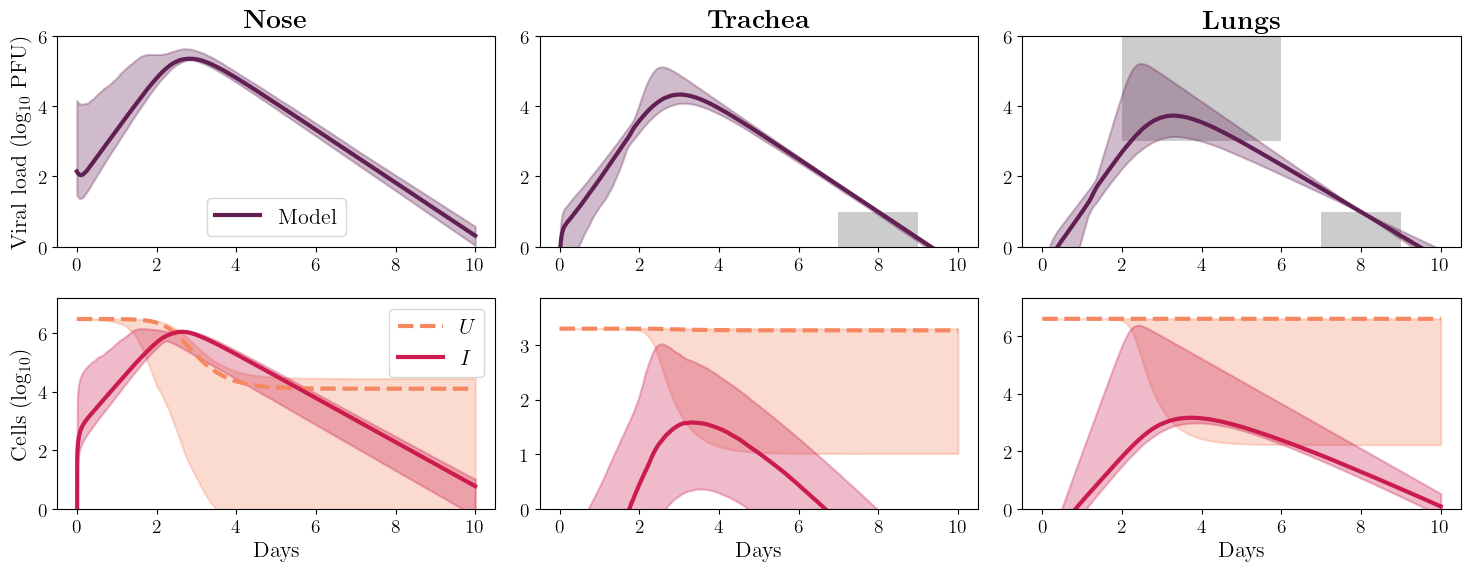

In [23]:
# Plots
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])

for i in range(3):
    idx = i*3 + 1
    # Row 1: V kinetics (columns)
    ax = fig.add_subplot(gs[0, i])
    ax.plot(dfV['Day'], safeLog10(dfV.iloc[:, idx]), color=rocket_pal[0], lw=3, label="Model")
    ax.fill_between(dfV['Day'], safeLog10(dfV.iloc[:, idx+1]), safeLog10(dfV.iloc[:, idx+2]),
                    color=rocket_pal[0], alpha=0.3, lw=1.5)
    if i == 0:
        ax.set_ylabel("Viral load (log$_{10}$ PFU)")
        ax.legend(loc='lower center')
        ax.set_title(r"\bf{Nose}")
    if i == 1:
        ax.set_title(r"\bf{Trachea}")
        tmin, tmax = 7, 9
        vmin, vmax = 0, 1
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)
    if i == 2:
        ax.set_title(r"\bf{Lungs}")
        tmin, tmax = 2, 6
        vmin, vmax = 3, 6
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1, label="Feasible window")
        ax.add_patch(rect)
        tmin, tmax = 7, 9
        vmin, vmax = 0, 1
        rect = plt.Rectangle((tmin, vmin), tmax-tmin, vmax-vmin, fc='gray', alpha = 0.4, zorder=-1)
        ax.add_patch(rect)
    ax.set_ylim((0, 6.0))

    # Row 2: U & I kinetics for i=1,2,3 (columns)
    ax = fig.add_subplot(gs[1, i])
    ax.plot(dfU['Day'], safeLog10(dfU.iloc[:, idx]), color=rocket_pal[2], lw=3, ls='--', label="$U$")
    ax.fill_between(dfU['Day'], safeLog10(dfU.iloc[:, idx+1]), safeLog10(dfU.iloc[:, idx+2]),
                    color=rocket_pal[2], alpha=0.3, lw=1.5)

    ax.plot(dfI['Day'], safeLog10(dfI.iloc[:, idx]), color=rocket_pal[1], lw=3, label="$I$")
    ax.fill_between(dfI['Day'], safeLog10(dfI.iloc[:, idx+1]), safeLog10(dfI.iloc[:, idx+2]),
                    color=rocket_pal[1], alpha=0.3, lw=1.5)
    
    if i == 0:
        ax.set_ylabel("Cells (log$_{10}$)")
        ax.legend(loc='upper right')
    ax.set_xlabel("Days")
    ax.set_ylim((0))
    

plt.tight_layout()

plt.show()

In [24]:
dfParams.columns = ['$V_1(0)$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$',
                    '$\\gamma_{12}$', '$\\gamma_{21}$', '$\\gamma_{23}$', '$\\gamma_{32}$']
dfParams

,$V_1(0)$,$\beta_1$,$\beta_2$,$\beta_3$,$\gamma_{12}$,$\gamma_{21}$,$\gamma_{23}$,$\gamma_{32}$
0,1.969270,-4.803477,-5.945701,-6.550583,-0.319774,-2.037741,-0.249380,-3.299412
1,1.893057,-4.814171,-4.450575,-6.916347,-0.339713,-1.189985,0.154235,-3.178387
2,1.868245,-4.804863,-4.879471,-6.777277,-0.318205,-2.113137,-0.004797,-2.174988
3,2.314538,-4.884572,-4.450046,-6.510985,-0.574728,-1.444545,-0.220272,-2.661360
4,4.485367,-5.094890,-6.270976,-4.214243,-2.756702,0.884929,-2.208265,0.998657
...,...,...,...,...,...,...,...,...
995,2.000967,-4.810319,-5.650998,-6.829311,-0.276572,-1.326085,0.059983,-3.018395
996,2.888848,-4.838179,-5.433259,-4.240106,-1.409884,0.897531,-1.659874,0.987922
997,2.287327,-4.847557,-5.746522,-6.727114,-0.360083,-2.504546,-0.031338,-3.057562
998,2.424149,-4.771495,-4.616886,-4.217102,-0.884800,0.964365,-2.055151,0.998795


In [25]:
dfParams.describe(percentiles=[0.025, 0.5, 0.975])

,$V_1(0)$,$\beta_1$,$\beta_2$,$\beta_3$,$\gamma_{12}$,$\gamma_{21}$,$\gamma_{23}$,$\gamma_{32}$
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.281444,-4.820652,-5.652655,-6.182087,-0.617634,-1.405066,-0.474229,-1.608541
std,0.632305,0.118612,0.774956,1.061967,0.636266,1.517458,0.865361,1.581470
min,0.991355,-6.631409,-6.999460,-6.999230,-3.074811,-3.990856,-3.834907,-3.998725
2.5%,1.471899,-5.051269,-6.872769,-6.995345,-2.312143,-3.822595,-2.675195,-3.786734
50%,2.142942,-4.820704,-5.713910,-6.657217,-0.346553,-1.626731,-0.099250,-2.034640
97.5%,4.159544,-4.582765,-4.144983,-4.193548,-0.106774,0.965825,0.215481,0.999831
max,4.499811,-4.024033,-4.003957,-4.172843,0.241258,0.999466,0.608012,1.000000


In [26]:
dfBootPars = dfParams.melt(var_name='Parameter', value_name='Value')
dfBootPars['Value'] = 10**dfBootPars['Value']

In [27]:
corrPars = dfParams.corr()
corrPars = np.round(corrPars, 1)        # round numerically
corrPars[corrPars == -0.0] = 0.0        # normalize -0.0 to 0.0

<Axes: >

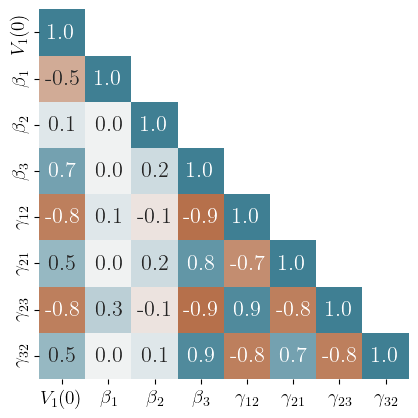

In [28]:
mask = np.triu(np.ones_like(corrPars, dtype=bool), k=1)

cmap =sns.diverging_palette(30, 220, as_cmap=True)
sns.heatmap(corrPars, annot=True, fmt='.1f', cmap=cmap, vmin=-1, vmax=1, mask=mask, cbar=False, square=True)

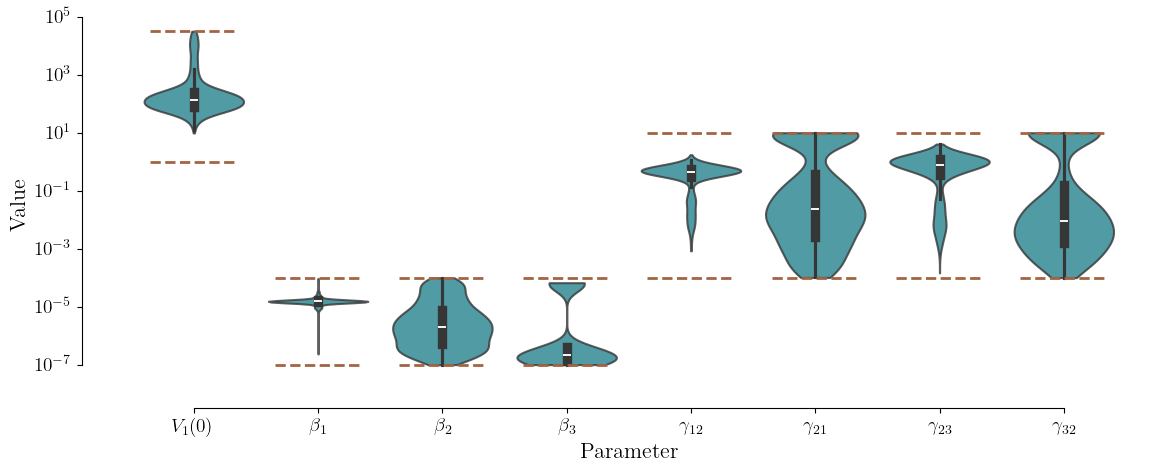

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), facecolor="white")

# Violin plot
sns.violinplot(
    data=dfBootPars,
    x="Parameter",
    y="Value",
    log_scale=True,
    cut=0,
    color=viridis_pal[3],
    alpha=0.8,
    linewidth=1.5,
    density_norm="count",
    saturation=1,
    ax=ax
)

# Bounds in log10
bounds = [
    (0, 4.5),                      # V1(0)
    (-7, -4), (-7, -4), (-7, -4),  # beta1–3
    (-4, 1), (-4, 1),              # gamma12, gamma21
    (-4, 1), (-4, 1),              # gamma23, gamma32
]

# Overlay bounds
for i, (bmin, bmax) in enumerate(bounds):
    ymin, ymax = 10**bmin, 10**bmax

    ax.hlines(
        [ymin, ymax],
        i - 0.35, i + 0.35,
        colors="#a36442",
        linestyles="--",
        linewidth=2,
        zorder=3
    )

ax.set_yscale("log")
ax.set_ylim(0.99e-8, 1e5)
sns.despine(ax=ax, offset=10, trim=True)

ax.legend([], [], frameon=False)

plt.tight_layout()

plt.show()

---
**END OF THE CODE**